##### Copyright 2020 The TensorFlow Authors.

In [5]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# MNIST classification

Based on https://www.tensorflow.org/quantum/tutorials/mnist

We build a quantum neural network (QNN) to classify a simplified version of MNIST, similar to the approach used in <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al</a>. The performance of the quantum neural network on this classical data problem is compared with a classical neural network.

## Setup

In [6]:
#!pip3 install -q tensorflow==2.3.1
!python3.8 -m pip install -q tensorflow==2.4.1
!python3.8 -m pip install tensorboard_plugin_profile==2.3.0
%load_ext tensorboard

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfq-nightly 0.5.0.dev20210516 requires grpcio==1.30.0, but you have grpcio 1.32.0 which is incompatible.
You should consider upgrading via the '/mnt/c/Users/mmints/Documents/Stanford/CS230/project/CS230_quantum_dropout/qenv_project/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/mnt/c/Users/mmints/Documents/Stanford/CS230/project/CS230_quantum_dropout/qenv_project/bin/python3.8 -m pip install --upgrade pip' command.
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Install TensorFlow Quantum:

In [7]:
#!pip3 install -q tensorflow-quantum
!python3.8 -m pip install tfq-nightly

  Using cached grpcio-1.30.0-cp38-cp38-manylinux2010_x86_64.whl (3.0 MB)
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires grpcio~=1.32.0, but you have grpcio 1.30.0 which is incompatible.
You should consider upgrading via the '/mnt/c/Users/mmints/Documents/Stanford/CS230/project/CS230_quantum_dropout/qenv_project/bin/python3.8 -m pip install --upgrade pip' command.


Now import TensorFlow and the module dependencies:

In [8]:
from tensorflow import keras
import pennylane as qml
from pennylane.templates import AmplitudeEmbedding
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections
import datetime
# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# set the random seed
tf.random.set_seed(137)
np.random.seed(137)

## 1. Load the data

In this tutorial you will build a binary classifier to distinguish between the digits 3 and 6, following <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> This section covers the data handling that:

- Loads the raw data from Keras.
- Filters the dataset to only 3s and 6s.
- Downscales the images so they fit can fit in a quantum computer.
- Removes any contradictory examples.
- Converts the binary images to Cirq circuits.
- Converts the Cirq circuits to TensorFlow Quantum circuits. 

### 1.1 Load the raw data

Load the MNIST dataset distributed with Keras. 

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


### State Preparation 
Before implementing the model circuit, Schuld et.al. conducts the state preparation. State preparation is the step in which we transfer the input vector into a n-qubit system of the quantum computer. Suppose that the input vector from the data is $R^{N}$. The mapping that takes this input into the quantum Hilbert space $C^{2n}$ is $\phi$. Schuld et. al. suggests to take the input vector $x \in R^{n}$ to be related to the amplitudes of the ket vectors in the $2^{n}$ dimensional Hilbert space (feature space). This is what is called **Amplitude Encoding**. 

#### Amplitude Encoding Requirement 

**If N is a power of 2**
1. Make the input vector size $N$ to be a power of 2, which makes us able to utilize all the possible amplitudes created by the n-qubit system of the quantum computer.  
2. input vector normalized to 1. 

**If N is *not* a power of 2**
1. Pad the input vector $x$, with non-zero features {c}, and normalize
$$(x_1,\cdots, x_{N})^{T} \rightarrow \frac{1}{\sqrt{\sum_{j}x_{j}^2 + \sum_{k}|c_{k}|^2}}(x_1,\cdots, x_{N}, c_1, \cdots, c_{D})^{T}$$
This basically embeds the input vector $x$ into a higher dimensional space. Padding width in the above notation is $D$. 

In the case of the MNIST data implementation by Schuld et. al, the MNIST data set input vectors are coarsed grained to 256 dimensions. This corresponds to $2^8$ where 8 represents 8-qubits. Thus implementation #1 in the amplitude encoding requirement is taken. 

For the MNIST dataset, Schuld et. al. deskews the dataset and then coarse grains each of the examples to an image with dimensions (16,16), since when flattened out, the image becomes a 16x16 = 256 dimensional vector. Before, the amplitude encoding, we will first deskew and coarse grain the dataset below. 

#### 1. Deskew the dataset 

The following moment and deskew functions were taken from the works of : 
1. https://stackoverflow.com/questions/43577665/deskew-mnist-images
2. https://fsix.github.io/mnist/Deskewing.html

First clean up the data with deskewing function. And then apply amplitude encoding. 

shape of x_train is (60000, 28, 28, 1)
type of x_train is <class 'numpy.ndarray'>
shape of x_test is (10000, 28, 28, 1)
type of x_test is <class 'numpy.ndarray'>
shape of x_train_deskew is (60000, 28, 28, 1)
type of x_train_deskew is <class 'numpy.ndarray'>
shape of x_test_deskew is (10000, 28, 28, 1)
type of x_test_deskew is <class 'numpy.ndarray'>


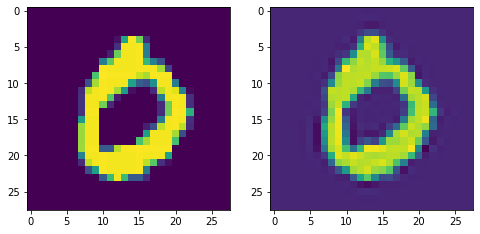

In [10]:
from scipy.ndimage import interpolation

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix
#Deskew the training samples 
def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    img = interpolation.affine_transform(image,affine,offset=offset)
    return (img - img.min()) / (img.max() - img.min())
examples = (4181, 0), (3,1), (56282, 2), (25829,3), (9741,4) , (26901,5), (50027,6), (17935,7) , (41495, 8), (14662, 9)

from mpl_toolkits.axes_grid1 import AxesGrid
grid = AxesGrid(plt.figure(figsize=(8,15)), 141,  # similar to subplot(141)
                    nrows_ncols=(10, 2),
                    axes_pad=0.05,
                    label_mode="1",
                    )

for examplenum,num in examples:
    im = grid[2*num].imshow(x_train[examplenum].reshape(28,28))
    im2 = grid[2*num+1].imshow(deskew(x_train[examplenum].reshape(28,28)))
plt.subplot(1, 2, 1)
plt.imshow(x_train[3].reshape(28,28))

newim = deskew(x_train[3].reshape(28,28))
plt.subplot(1, 2, 2)
plt.imshow(newim)

print("shape of x_train is " + str(x_train.shape))
print("type of x_train is " + str(type(x_train)))
print("shape of x_test is " + str(x_test.shape))
print("type of x_test is " + str(type(x_test)))


#store the deskwed x_train into a list x_test_deskew
#store the deskwed x_test into a list x_test_deskew

#training set 
x_train_deskew = [] 
for i in range(x_train.shape[0]): 
    x_train_deskew.append(deskew(x_train[i].reshape(28,28)))
x_train_deskew = np.array(x_train_deskew)
x_train_deskew = x_train_deskew[..., np.newaxis]
print("shape of x_train_deskew is " + str(np.shape(x_train_deskew)))
print("type of x_train_deskew is " + str(type(x_train_deskew)))

#test set 
x_test_deskew = [] 
for j in range(x_test.shape[0]): 
    x_test_deskew.append(deskew(x_test[j].reshape(28,28)))
x_test_deskew = np.array(x_test_deskew)
x_test_deskew = x_test_deskew[..., np.newaxis]
print("shape of x_test_deskew is " + str(np.shape(x_test_deskew)))
print("type of x_test_deskew is " + str(type(x_test_deskew)))


#We should have the deskewed image stored within x_train
#original 
plt.subplot(1, 2, 1)
plt.imshow(x_train[3].reshape(28,28))

#deskewed 
plt.subplot(1, 2, 2)
plt.imshow(x_train_deskew[3])


#We should have the deskewed image stored within x_test 
#original
plt.subplot(1, 2, 1)
plt.imshow(x_test[3].reshape(28,28))

#deskewed
plt.subplot(1, 2, 2)
plt.imshow(x_test_deskew[3])

Filter the dataset to keep just the 3s and 6s,  remove the other classes. At the same time convert the label, `y`, to boolean: `True` for `3` and `False` for 6. 

In [11]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [12]:
print(x_train_deskew.shape)
print(y_train.shape)
print(x_train.shape)
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

(60000, 28, 28, 1)
(60000,)
(60000, 28, 28, 1)
Number of filtered training examples: 12049
Number of filtered test examples: 1968


Show the first example:

True


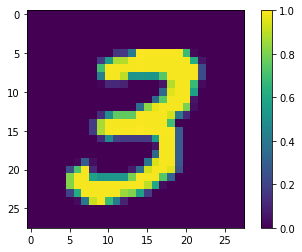

In [13]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

### 1.2 Downscale the images

An image size of 28x28 is much too large for current quantum computers. Resize the image down to 4x4:

In [14]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

Again, display the first training example—after resize: 

True


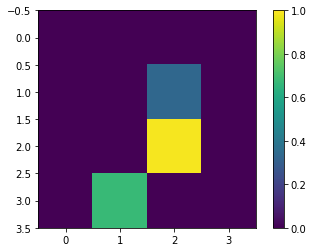

In [15]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

### 1.3 Remove contradictory examples

From section *3.3 Learning to Distinguish Digits* of <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a>, filter the dataset to remove images that are labeled as belonging to both classes.

This is not a standard machine-learning procedure, but is included in the interest of following the paper.

In [16]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass
    
    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

The resulting counts do not closely match the reported values, but the exact procedure is not specified.

It is also worth noting here that applying filtering contradictory examples at this point does not totally prevent the model from receiving contradictory training examples: the next step binarizes the data which will cause more collisions. 

In [17]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 3 and 6):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


In [18]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [19]:
# Duplicate some entries to illustrate the effects of dropout! Run this cell only if testing dropout
NUM_DUPLICATE = 200

for i in range(NUM_DUPLICATE):
    x_train_nocon = np.insert(x_train_nocon, 0, x_train_bin[0], axis=0)
    y_train_nocon = np.insert(y_train_nocon, 0, y_train_nocon[0], axis=0)
print(x_train_nocon.shape)
print(y_train_nocon.shape)

(10538, 4, 4, 1)
(10538,)


### 1.4 Encode the data as quantum circuits

To process images using a quantum computer, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed representing each pixel with a qubit, with the state depending on the value of the pixel. The first step is to convert to a binary encoding.

If you were to remove contradictory images at this point you would be left with only 193, likely not enough for effective training.

In [20]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 193
Number of unique 3s:  32
Number of unique 6s:  37
Number of unique contradicting labels (both 3 and 6):  124

Initial number of images:  10338
Remaining non-contradicting unique images:  69


The qubits at pixel indices with values that exceed a threshold, are rotated through an $X$ gate.

In [21]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

Here is the circuit created for the first example (circuit diagrams do not show qubits with zero gates):

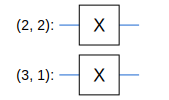

In [22]:
SVGCircuit(x_train_circ[0])

Compare this circuit to the indices where the image value exceeds the threshold:

In [23]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

Convert these `Cirq` circuits to tensors for `tfq`:

In [24]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

## 2. Quantum neural network

There is little guidance for a quantum circuit structure that classifies images. Since the classification is based on the expectation of the readout qubit, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> propose using two qubit gates, with the readout qubit always acted upon. This is similar in some ways to running small a <a href="https://arxiv.org/abs/1511.06464" class="external">Unitary RNN</a> across the pixels.

Helper functions for Tensorboard.


- The integer values of samples, so that you can create histograms of the distribution.
- The linear XEB fidelity estimate of a set of samples, to give some indication of how "truly quantum random" the samples are.


In [25]:
@tf.function
def bits_to_ints(bits):
    """Convert tensor of bitstrings to tensor of ints."""
    sigs = tf.constant([1 << i for i in range(N_QUBITS)], dtype=tf.int32)
    rounded_bits = tf.clip_by_value(tf.math.round(
        tf.cast(bits, dtype=tf.dtypes.float32)), clip_value_min=0, clip_value_max=1)
    return tf.einsum('jk,k->j', tf.cast(rounded_bits, dtype=tf.dtypes.int32), sigs)

@tf.function
def xeb_fid(bits):
    """Compute linear XEB fidelity of bitstrings."""
    final_probs = tf.squeeze(
        tf.abs(tfq.layers.State()(REFERENCE_CIRCUIT).to_tensor()) ** 2)
    nums = bits_to_ints(bits)
    return (2 ** N_QUBITS) * tf.reduce_mean(tf.gather(final_probs, nums)) - 1.0


From the above, we see that we successfully converted the original MNIST x_train into the deskewed x_train_deskewed. New, we coarse grain the (28,28) image to (16,16). 

#### 2. Downscaling (Coarse Graining) deskewed image from (28,28) -> (16,16)
Schuld et. al. coarse grains a single training example from the MNIST dataset to a vector of 256 dimensions. 
The original MNIST dataset is of dimension 28x28 = 784 (if each example is flattened out). Flattening out 16x16 = 256 dimensions. 

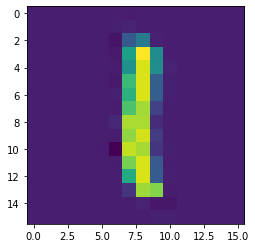

In [26]:
x_train_coarse = tf.image.resize(x_train_deskew, (16,16)).numpy()
x_test_coarse = tf.image.resize(x_test_deskew, (16,16)).numpy()
plt.imshow(x_train_coarse[3])

#### 3. Flatten the image to normalized 256-dimensional vector

In [27]:
#storage for flattend x_train_coarse vectors 
x_train_coarse_flat = np.zeros((x_train_coarse.shape[0],256))
for i in range(x_train.shape[0]): 
    x_flat = x_train_coarse[i].flatten()
    norm = np.linalg.norm(x_flat)
    norm_x_flat = x_flat/norm
    x_train_coarse_flat[i,:] = norm_x_flat

    
#storage for flattend x_test_coarse vectors 
x_test_coarse_flat = np.zeros((x_test_coarse.shape[0],256))
for i in range(x_test.shape[0]): 
    x_flat = x_test_coarse[i].flatten()
    norm = np.linalg.norm(x_flat)
    norm_x_flat = x_flat/norm
    x_test_coarse_flat[i,:] = norm_x_flat
    
print("shape of x_train_coarse_flat is " + str(np.shape(x_train_coarse_flat)))
print("check if normalized : " + str(np.sqrt(x_train_coarse_flat[3,:].dot(x_train_coarse_flat[3,:]))))

shape of x_train_coarse_flat is (60000, 256)
check if normalized : 0.9999999994396633


We successfully flattened the deskewed + coarse grained data set to a normalized 256-dimensional vector. 

#### 4. Apply amplitude embedding on the dataset.
We use the pennylane Amplitude embedding method.

In [28]:
channels = 8 # the number of channels is taken from schuld implementation.
dev = qml.device('default.qubit', wires=channels)

@qml.qnode(dev)
def circuit(f=None,channels=8):
    AmplitudeEmbedding(features=f, wires=range(channels))
    return qml.expval(qml.PauliZ(0))

circuit(f=x_train_coarse_flat[0,:])
print(x_train_coarse_flat[0,:])
print(dev.state)

[0.0116099  0.01160989 0.01160967 0.01160916 0.01161146 0.01161371
 0.01161433 0.01160899 0.01159702 0.01160656 0.01158849 0.01158695
 0.01160782 0.0116097  0.0116099  0.0116099  0.01160989 0.01160992
 0.01161097 0.01161348 0.01160245 0.01159234 0.0115901  0.01161476
 0.01167109 0.01162117 0.01171254 0.01171549 0.01161499 0.01161142
 0.01160985 0.0116099  0.0116099  0.01160986 0.01160885 0.01168735
 0.01159235 0.01113598 0.01099782 0.01096042 0.01291967 0.01351303
 0.01310598 0.01510118 0.0128954  0.01160156 0.01161015 0.0116099
 0.01160842 0.01162058 0.01191654 0.01623252 0.03229045 0.07283596
 0.10727166 0.12864868 0.15317373 0.15911235 0.13035896 0.1793035
 0.07811258 0.00938078 0.01159267 0.0116099  0.0116095  0.01161269
 0.01169003 0.0421715  0.18415603 0.1871769  0.18673553 0.1756878
 0.17413333 0.14799191 0.04609891 0.03550546 0.01790038 0.01196682
 0.01161832 0.0116099  0.01161066 0.01160471 0.0114609  0.01029056
 0.06660093 0.08121876 0.18484472 0.08283664 0.01250172 0.0901629

In [29]:
num_category = 10
y_train_onehot = keras.utils.to_categorical(y_train, num_category)
y_test_onehot = keras.utils.to_categorical(y_test, num_category)

### 2.1 Build the model circuit

This following example shows this layered approach. Each layer uses *n* instances of the same gate, with each of the data qubits acting on the readout qubit.

Start with a simple class that will add a layer of these gates to a circuit:

In [31]:
print(tfq.util.get_supported_gates().keys())
print(tfq.util.get_supported_channels().keys())

class CircuitLayerBuilder():
    def __init__(self, circuit, data_qubits, repeat_dropout=0, overlap_dropout=False):
        
        self.data_qubits = data_qubits
        #self.readout = readout
        self.curr_layer_id = 0
        self.circuit = circuit

        
        # dropout
        self.dropped_out_qubit_ids = []
        self.dropout_blacklist = []
        
        self.overlap_dropout = overlap_dropout
        
        if repeat_dropout < 1:
            repeat_dropout = 1
        if overlap_dropout:
            for _ in range(repeat_dropout - 1):
                # We will be dequeing from this on each rebuild;
                # so, each qubit will be in the list for repeat_dropout rebuilds.
                self.dropped_out_qubit_ids.append(len(self.data_qubits))
            self.delay_next_dropout = 1
        else:
            # if not overlapping, delay for as long as we're repeating
            self.delay_next_dropout = repeat_dropout
            
        self.delay_next_dropout_i = 0 # try to dropout immediately
        
        # maps str(symbol) to (is_dropped_out, weight)
        self.symbol_map = {}
        
        self.drop_out_applied = False
        
    def rebuild(self, circuit, data_qubits, computed_weights, preserve_dropout=False):
        # prev_weights is the result of get_weights from the prior epoch.
        
        self.data_qubits = data_qubits
        self.curr_layer_id = 0
        self.circuit = circuit
        
        if preserve_dropout:
            if self.overlap_dropout and len(self.dropped_out_qubit_ids) > 0 and self.drop_out_applied:
                # Dropping first element. This is either padding, or an actual id that we want to stop dropping out from here on.
                dropped_id = self.dropped_out_qubit_ids.pop(0)
                self.dropout_blacklist.append(dropped_id)
        else:
            self.dropout_blacklist = []
            self.dropped_out_qubit_ids = []
        
        if self.delay_next_dropout_i > 0:
            self.delay_next_dropout_i -= 1
        
        if self.delay_next_dropout_i == 0 and not self.overlap_dropout:
            # Dropout finished for this qubit!
            assert len(self.dropped_out_qubit_ids) <= 1
            if len(self.dropped_out_qubit_ids) == 1:
                self.dropout_blacklist.append(self.dropped_out_qubit_ids[0])
            self.dropped_out_qubit_ids = []
        
        self.drop_out_applied = False
        
        print('self.dropped_out_qubit_ids = ')
        print(self.dropped_out_qubit_ids)
        
        j = 0
        
        #print('Rebuilding; prev self.symbol_map:')
        #print(self.symbol_map)
        
        for k in sorted(self.symbol_map.keys()):
            prev_is_dropped_out, _ = self.symbol_map[k]
            if not prev_is_dropped_out:
                # Re-use the prev weight. This isn't directly used as TFQ inputs, but we later use it to generate
                # sane inputs for set_weights().
                # Also, is-dropped-out is True by default to handle the case when a rebuilt circuit might not add a layer for some reason
                self.symbol_map[k] = (True, computed_weights[j])

                # prev_weights is a list that only has entries for non-dropped-out elems
                j += 1
                
        #print('Rebuilding done; updated self.symbol_map:')
        #print(self.symbol_map)
    
    def add_layer(self, gate, block=1,apply_dropout=False):
        # at most one dropped qubit added per layer
        self.block = block
        if apply_dropout and self.curr_layer_id > 0 and self.delay_next_dropout_i == 0:
            while True:
                rand_id = np.random.randint(0, len(self.data_qubits) * 2 + 1)
                if rand_id >= len(self.data_qubits):
                    rand_id = len(self.data_qubits)
                # Kinda hacky, blacklist qubits that we dropped out already
                if rand_id not in self.dropout_blacklist or rand_id == len(self.data_qubits):
                    break
            print('self.dropout_blacklist =')
            print(self.dropout_blacklist)
            #print(rand_id)
            if rand_id not in self.dropped_out_qubit_ids and rand_id != len(self.data_qubits):
                self.dropped_out_qubit_ids.append(rand_id)
            if rand_id != len(self.data_qubits):
                self.delay_next_dropout_i = self.delay_next_dropout # reset delay if we're actually going to drop out!

        
        # first apply the initial single qubit gates
        for i in range(len(self.data_qubits)):
            qubit = self.data_qubits[i]
            symbol = sympy.Symbol('sym_l' + str(self.curr_layer_id) + '_q' + str(i))
            if str(symbol) in self.symbol_map:
                _, weight = self.symbol_map[str(symbol)]
            else:
                # default value for weight is 0
                weight = 0
            if i in self.dropped_out_qubit_ids:# and self.curr_layer_id > 0:
                print("Dropped out qubit id " + str(i))
                self.symbol_map[str(symbol)] = (True, weight)
                self.drop_out_applied = True
            else:
                self.symbol_map[str(symbol)] = (False, weight)
                self.circuit.append(gate(qubit)**symbol)

        # according to the block num create the control gates

        # add control gate version of the unitary gate if available (ie cz, cnot).
        if gate == cirq.XX:
            cgate = cirq.CNOT
        elif gate == cirq.Z:
            cgate = cirq.CZ
        else:
            cgate = cirq.CNOT
        target = None
        control = None
        for i in range(len(self.data_qubits)):
            if block > 0 :
                symbol = sympy.Symbol('sym_l' + str(self.curr_layer_id) + '_q' + str(i)+ 'block'+str(block))
                if str(symbol) in self.symbol_map:
                    _, weight = self.symbol_map[str(symbol)]
                else:
                    # default value for weight is 0
                    weight = 0
                if control is None:
                    control_idx = i
                    control = self.data_qubits[i]
                # determine control
                target_idx = (control_idx+len(self.data_qubits)-block)%len(self.data_qubits)
                target = self.data_qubits[target_idx]
                # add gate
                self.symbol_map[str(symbol)] = (False, weight)
                self.circuit.append(cgate(control,target)**symbol)
                control = target
                control_idx = target_idx
            else:
                break #trimmed circuit doesn't include entanglements
                
        self.curr_layer_id += 1
    
    def get_builder_weights(self):
        # returns symbol names in sorted order, which should match the order used for PQC (kinda hacky and can potentially break later)
        # used as the next input for set_weights()
        #
        # Order of calls:
        # tf.fit();
        # builder.rebuild(tf.get_weights());
        # add_layer()...;
        # tf.set_weights(builder.get_builder_weights());
        # tf.fit()
        weights_list = []
        
        for k in sorted(self.symbol_map.keys()):
            curr_is_dropout, curr_weight = self.symbol_map[k]
            if not curr_is_dropout:
                weights_list.append(curr_weight)
        
        return weights_list

dict_keys([cirq.X, cirq.XX, cirq.Y, cirq.YY, cirq.Z, cirq.ZZ, cirq.H, cirq.CZ, cirq.CNOT, cirq.SWAP, cirq.ISWAP, cirq.PhasedXPowGate(phase_exponent=0.123), cirq.PhasedISwapPowGate(phase_exponent=0.123), cirq.FSimGate(theta=0.123, phi=0.456), cirq.I])
dict_keys([cirq.depolarize(p=0.01), cirq.asymmetric_depolarize(error_probabilities={'I': 0.94, 'X': 0.01, 'Y': 0.02, 'Z': 0.03}), cirq.generalized_amplitude_damp(p=0.01,gamma=0.02), cirq.amplitude_damp(gamma=0.01), cirq.ResetChannel(), cirq.phase_damp(gamma=0.01), cirq.phase_flip(p=0.01), cirq.bit_flip(p=0.01)])


self.dropout_blacklist =
[]
Dropped out qubit id 6


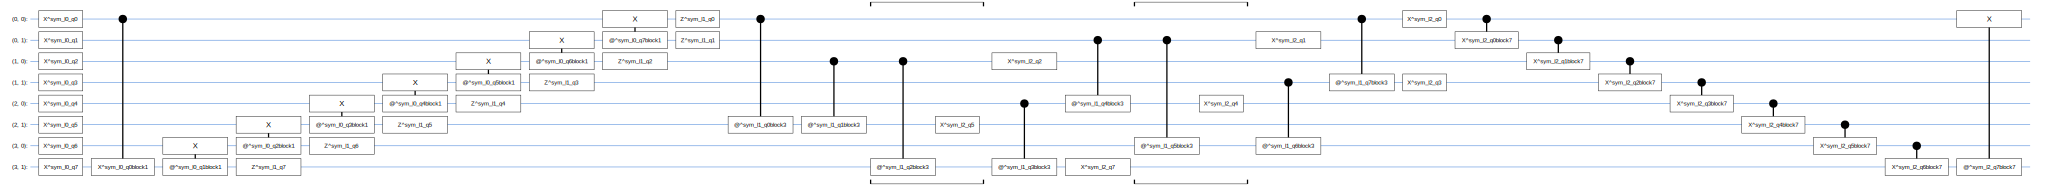

In [32]:
# TEST CELL to make sure CircuitLayerBuilder works properly
circuit = cirq.Circuit()
demo_builder = CircuitLayerBuilder(circuit=circuit,
                                   data_qubits = cirq.GridQubit.rect(4,2),
                                   )
demo_builder.add_layer(gate=cirq.X,block=1)
demo_builder.add_layer(gate=cirq.Z,block=3)
demo_builder.add_layer(gate=cirq.X,block=7,apply_dropout=True)
SVGCircuit(circuit)

Build an example circuit layer to see how it looks:

Now build a two-layered model, matching the data-circuit size, and include the preparation and readout operations.

In [ ]:
def create_quantum_model(apply_dropout=False, n_dropout=5, builder=None, computed_weights_arr=None):
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 2)  # a 4x4 grid.
    circuit = cirq.Circuit()
    
    
    if builder is None or computed_weights_arr is None:
        builder = CircuitLayerBuilder(
            circuit=circuit,
            data_qubits=data_qubits,
            repeat_dropout=n_dropout)
    else:
        builder.rebuild(circuit, data_qubits, readout, computed_weights_arr, preserve_dropout=apply_dropout)

    # Then add layers (TODO: experiment by adding more).
    builder.add_layer(cirq.X,1, apply_dropout = False)
    builder.add_layer(cirq.Z,3, apply_dropout) # only drop out one qubit as per Schuld
    #builder.add_layer(cirq.X,7, False)

    # Finally, prepare the readout qubit.

    return builder, circuit, cirq.X(data_qubits[0])

In [ ]:
_, model_circuit, model_readout = create_quantum_model(apply_dropout=True)
SVGCircuit(model_circuit)

### 2.2 Wrap the model-circuit in a tfq-keras model

Build the Keras model with the quantum components. This model is fed the "quantum data", from `x_train_circ`, that encodes the classical data. It uses a *Parametrized Quantum Circuit* layer, `tfq.layers.PQC`, to train the model circuit, on the quantum data.

To classify these images, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed taking the expectation of a readout qubit in a parameterized circuit. The expectation returns a value between 1 and -1.

In [ ]:
# Build the Keras model.
qlayer = tfq.layers.PQC(model_circuit, model_readout,repetitions=5000)
print(len(qlayer.get_weights()[0]))
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    qlayer,
])

Next, describe the training procedure to the model, using the `compile` method.

Since the the expected readout is in the range `[-1,1]`, optimizing the hinge loss is a somewhat natural fit. 

Note: Another valid approach would be to shift the output range to `[0,1]`, and treat it as the probability the model assigns to class `3`. This could be used with a standard a `tf.losses.BinaryCrossentropy` loss.

To use the hinge loss here you need to make two small adjustments. First convert the labels, `y_train_nocon`, from boolean to `[-1,1]`, as expected by the hinge loss.

In [ ]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

Second, use a custiom `hinge_accuracy` metric that correctly handles `[-1, 1]` as the `y_true` labels argument. 
`tf.losses.BinaryAccuracy(threshold=0.0)` expects `y_true` to be a boolean, and so can't be used with hinge loss).

In [ ]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [ ]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
print(model.summary())

## 3. TensorBoard

In [ ]:
logdir = "tb_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)


### Train the quantum model

Now train the model—this takes about 45 min. If you don't want to wait that long, use a small subset of the data (set `NUM_EXAMPLES=500`, below). This doesn't really affect the model's progress during training (it only has 32 parameters, and doesn't need much data to constrain these). Using fewer examples just ends training earlier (5min), but runs long enough to show that it is making progress in the validation logs.

In [ ]:
EPOCHS = 20
DROPOUT_EPOCHS = 2 # keep qubits dropped out for this num of epochs
BATCH_SIZE = 32
NUM_EXAMPLES = 500 #len(x_train_tfcirc)
#NUM_EXAMPLES=None

In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]
tf.print(x_train_tfcirc_sub[0])

In [ ]:
x_train_coarse_sub = x_train_coarse_flat[:NUM_EXAMPLES]
print(x_train_coarse_sub .shape)
y_train_coarse_sub = y_train_onehot[:NUM_EXAMPLES]

In [ ]:
model.fit(
  x_train_tfcirc_sub, y_train_hinge_sub,
  batch_size=32,
  epochs=EPOCHS,
  verbose=1,
  validation_data=(x_test_tfcirc, y_test_hinge),
  callbacks=[tensorboard_callback])

Training this model to convergence should achieve >85% accuracy on the test set.

In [ ]:
def train_model(apply_dropout=False):
    for i in range(EPOCHS):        
        # HACK - build new quantum circuit for each epoch and copy over the weights from the old one
        if i == EPOCHS-1:
            # Never use dropout on the last epoch; we can't get sane results otherwise
            apply_dropout = False
        
        if i == 0:
            model_builder, model_circuit, model_readout = create_quantum_model(apply_dropout, DROPOUT_EPOCHS)
            qlayer = tfq.layers.PQC(model_circuit, model_readout)
        else:
            model_builder, model_circuit, model_readout = create_quantum_model(apply_dropout, -1, model_builder, qlayer.get_weights()[0])
            qlayer_new = tfq.layers.PQC(model_circuit, model_readout,
                                        initializer=tf.keras.initializers.Zeros)
            curr_l = model_builder.get_builder_weights()
            qlayer_new.set_weights([np.array(curr_l, dtype=np.float32)])
            qlayer = qlayer_new

        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(), dtype=tf.string),
            qlayer,
        ])
        model.compile(
            loss=tf.keras.losses.Hinge(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[hinge_accuracy])

        # Now fit the model for this epoch
        model.fit(
              x_train_tfcirc_sub, y_train_hinge_sub,
              batch_size=32,
              epochs=1,
              verbose=1,
              validation_data=(x_test_tfcirc, y_test_hinge),
              callbacks=[tensorboard_callback])
    print(model.loss())
    tf.summary.scalar('loss', train_loss.result(), step=i)
    tf.summary.scalar('accuracy', train_accuracy.result(), step=i)
    return model

In [ ]:
model = train_model(apply_dropout=False)

In [ ]:
print("Non-dropout training set perf:")
model.evaluate(x_train_tfcirc_sub, y_train_hinge_sub)
print("Non-dropout test set perf:")
qnn_results = model.evaluate(x_test_tfcirc, y_test)

In [ ]:
dropout_model = train_model(apply_dropout=True)

In [ ]:
print("Dropout training set perf:")
dropout_model.evaluate(x_train_tfcirc_sub, y_train_hinge_sub)
print("Dropout test set perf:")
qnn_results = dropout_model.evaluate(x_test_tfcirc, y_test)

Note: The training accuracy reports the average over the epoch. The validation accuracy is evaluated at the end of each epoch.

## 4. Classical neural network

While the quantum neural network works for this simplified MNIST problem, a basic classical neural network can easily outperform a QNN on this task. After a single epoch, a classical neural network can achieve >98% accuracy on the holdout set.

In the following example, a classical neural network is used for for the 3-6 classification problem using the entire 28x28 image instead of subsampling the image. This easily converges to nearly 100% accuracy of the test set.

In [ ]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

In [ ]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

The above model has nearly 1.2M parameters. For a more fair comparison, try a 37-parameter model, on the subsampled images:

In [ ]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

In [ ]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

## 5. Comparison

Higher resolution input and a more powerful model make this problem easy for the CNN. While a classical model of similar power (~32 parameters) trains to a similar accuracy in a fraction of the time. One way or the other, the classical neural network easily outperforms the quantum neural network. For classical data, it is difficult to beat a classical neural network.

In [ ]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(["Quantum", "Classical, full", "Classical, fair"],
            [qnn_accuracy, cnn_accuracy, fair_nn_accuracy])